# Extended Isolation Forest Example

**Goal** 

Show how to use IF/EIF algorithms from the `eif` library and verify if EIF indeed performs better.

**Introduction** 

For this short exercise I use Forest Cover dataset downloaded from [here](http://odds.cs.stonybrook.edu/forestcovercovertype-dataset/). Below you can find a detailed description of the dataset, as given on the website. The dataset contains 286048 observations and 10 features. The observations are labeled, so we do know up front which ones are anomalous. 

Another aspect of the comparison can be speed, as the authors of the [paper](https://arxiv.org/abs/1811.02141) state that there is no (significant) decrease in speed in Extended Isolation Forest

*Dataset Description*

The original ForestCover/Covertype dataset from UCI machine learning repository is a multiclass classification dataset. It is used in predicting forest cover type from cartographic variables only (no remotely sensed data). This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. This dataset has 54 attributes (10 quantitative variables, 4 binary wilderness areas and 40 binary soil type variables). Here, outlier detection dataset is created using only 10 quantitative attributes. Instances from class 2 are considered as normal points and instances from class 4 are anomalies. The anomalies ratio is 0.9%. Instances from the other classes are omitted.

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy.stats import multivariate_normal

from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import euclidean_distances
import eif as iso

# default plot settings
%matplotlib inline

## UDF

In [2]:
def pretty_cm(y_pred, y_truth, labels):
    '''
    'Pretty' implementation of a confusion matrix with some evaluation statistics.
    
    Input:
    y_pred - object with class predictions from the model
    y_truth - object with actual classes
    labels - list containing label names
    '''
    
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Confusion Matrix', size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    print('#######################')
    print('Evaluation metrics ####')
    print('#######################')
    print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_truth, y_pred)))
    print('Precision: {:.4f}'.format(metrics.precision_score(y_truth, y_pred)))
    print('Recall: {:.4f}'.format(metrics.recall_score(y_truth, y_pred)))
    print('F1: {:.4f}'.format(metrics.f1_score(y_truth, y_pred)))

## Loading Data

In [3]:
mat = scipy.io.loadmat('cover.mat')
X = pd.DataFrame(mat['X'])
y = pd.Series([x[0] for x in mat['y']])

In [4]:
X.shape

(286048, 10)

In [13]:
X.describe()

,0,1,2,3,4,5,6,7,8,9
count,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000
mean,2914.242610,151.917224,13.598309,278.255251,45.839107,2414.978643,213.983685,225.246605,142.680092,2155.583857
std,197.987324,107.488551,7.138464,210.458091,57.504597,1618.090012,24.955931,18.551910,36.501454,1423.976520
min,1988.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2788.000000,60.000000,8.000000,120.000000,8.000000,1123.000000,201.000000,215.000000,120.000000,1165.000000
50%,2933.000000,126.000000,13.000000,240.000000,30.000000,2016.000000,219.000000,227.000000,142.000000,1832.000000
75%,3041.000000,241.000000,18.000000,390.000000,67.000000,3386.000000,232.000000,239.000000,167.000000,2647.000000
max,3433.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


## Isolation Forest

In all models I will try to use the same settings, meaning:
* number of trees in the forest = 100
* maximum number of samples to draw for estimating each tree = 256
* I know up front that there is 0.9% anomalies in the dataset and I will use this percentage to select the highest anomaly scores

### Scikit-Learn

In [5]:
# define % of anomalies
anomalies_ratio = 0.009

if_sk = IsolationForest(n_estimators = 100, 
                        max_samples = 256,
                        contamination = anomalies_ratio, 
                        behaviour= " new", 
                        random_state = np.random.RandomState(42))
if_sk.fit(X)
y_pred = if_sk.predict(X)
y_pred = [1 if x == -1 else 0 for x in y_pred]

#######################
Evaluation metrics ####
#######################
Accuracy: 0.9831
Precision: 0.0924
Recall: 0.0866
F1: 0.0894


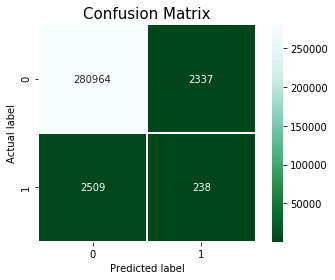

In [6]:
pretty_cm(y_pred, y, [0, 1])

The Forest is able to correctly identify 8.7% of anomalies in the dataset.

### eif

By setting `ExtensionLevel` to 0 I am estimating a regular Isolation Forest. A couple of words about this implementation. First of all, as of now there is no way of setting random state for the model, so running it multiple times might yield different results. Also the `eif` implementation does not have that many parameters to configure. 

Another thing is that the model predicts the anomaly scores, but does not automatically identify which observations are considered outliers. To identify the anomalies, I sort the anomaly scores and retrieve indices of 0.9% of observations with highest scores.

In [8]:
if_eif = iso.iForest(X.values, 
                     ntrees = 100, 
                     sample_size = 256, 
                     ExtensionLevel = 0)

# calculate anomaly scores
anomaly_scores = if_eif.compute_paths(X_in = X.values)
# sort the scores
anomaly_scores_sorted = np.argsort(anomaly_scores)
# retrieve indices of anomalous observations
indices_with_preds = anomaly_scores_sorted[-int(np.ceil(anomalies_ratio * X.shape[0])):]
# create predictions 
y_pred = np.zeros_like(y)
y_pred[indices_with_preds] = 1

#######################
Evaluation metrics ####
#######################
Accuracy: 0.9826
Precision: 0.0672
Recall: 0.0630
F1: 0.0650


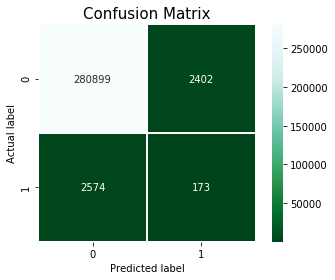

In [9]:
pretty_cm(y_pred, y, [0, 1])

## Extended Isolation Forest

This part is very similar to the vanilla Isolation Forest case (`eif` implementation) with the difference being the `ExtensionLevel`. To work on fully extended level, I set the level to 9 (number of dimensions - 1).

In [10]:
eif = iso.iForest(X.values, 
                  ntrees = 100, 
                  sample_size = 256, 
                  ExtensionLevel = X.shape[1] - 1)

anomaly_scores = eif.compute_paths(X_in = X.values)
anomaly_scores_sorted = np.argsort(anomaly_scores)
indices_with_preds = anomaly_scores_sorted[-int(np.ceil(anomalies_ratio * X.shape[0])):]
y_pred = np.zeros_like(y)
y_pred[indices_with_preds] = 1

#######################
Evaluation metrics ####
#######################
Accuracy: 0.9814
Precision: 0.0000
Recall: 0.0000
F1: 0.0000


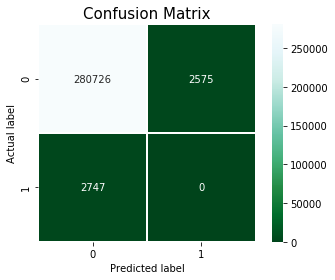

In [11]:
pretty_cm(y_pred, y, [0, 1])

As can be seen in the results, the model fails to identify a single anomaly in the dataset. Unfortunately, I do not have any explanation for this and if anyone knows what the issue might be, please let me know.

## Conclusions

The Extended Isolation Forest algorithm certainly is interesting and worth further exploring. It easily overcomes the limitations of the original model on a set of artificial examples, however, there seems to be some kind of problem when implementing it on a real life dataset. What is more, the current eif implementation is nearly as fast as the sklearn one. On my Macbook Pro the sklearn IF took 14s to train, while the eif implementations took roughly 10 minutes.

I really hope the algorithm will be further improved and will serve as a good tool for identifying anomalies.